Bank Customer Machine Learning Model

In [28]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler 
from sklearn import preprocessing
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score

In [163]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

In [29]:
data = pd.read_csv(r"data/Bank.csv")
print(data.shape)
print("Features count:",data.shape[1])
print("Raw count:",data.shape[0])

data.head()

(10000, 12)
Features count: 12
Raw count: 10000


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [30]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,10000.0,1.569094e+07,71936.186123,15565701.00,15628528.25,1.569074e+07,1.575323e+07,15815690.00
credit_score,10000.0,6.505288e+02,96.653299,350.00,584.00,6.520000e+02,7.180000e+02,850.00
age,10000.0,3.892180e+01,10.487806,18.00,32.00,3.700000e+01,4.400000e+01,92.00
tenure,10000.0,5.012800e+00,2.892174,0.00,3.00,5.000000e+00,7.000000e+00,10.00
balance,10000.0,7.648589e+04,62397.405202,0.00,0.00,9.719854e+04,1.276442e+05,250898.09
products_number,10000.0,1.530200e+00,0.581654,1.00,1.00,1.000000e+00,2.000000e+00,4.00
credit_card,10000.0,7.055000e-01,0.455840,0.00,0.00,1.000000e+00,1.000000e+00,1.00
active_member,10000.0,5.151000e-01,0.499797,0.00,0.00,1.000000e+00,1.000000e+00,1.00
estimated_salary,10000.0,1.000902e+05,57510.492818,11.58,51002.11,1.001939e+05,1.493882e+05,199992.48
churn,10000.0,2.037000e-01,0.402769,0.00,0.00,0.000000e+00,0.000000e+00,1.00


In [31]:
data['churn'].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

In [32]:
# Customer ID feature is dropped.
data = data.drop("customer_id",axis=1)
data.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [33]:
# Empty feature check
print(data.isnull().sum())

credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64


In [35]:
# Input features
X_original = data.drop("churn",axis=1)
X_original.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [36]:
X_original.corr()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
credit_score,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384
age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201
tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784
balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797
products_number,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204
credit_card,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933
active_member,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421
estimated_salary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000


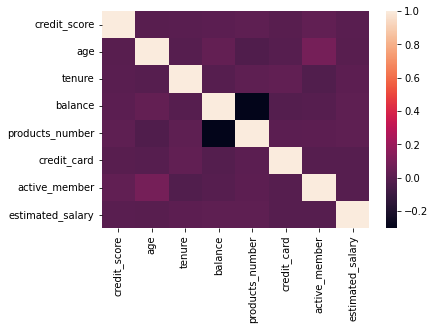

In [37]:
sns.heatmap(X_original.corr());

In [38]:
print("Age min:{}  Age mean:{}  Age max:{}".format(data["age"].min(),data["age"].mean(),data["age"].max()))

Age min:18  Age mean:38.9218  Age max:92


In [39]:
print("Tenure min:{}  Tenure mean:{}  Tenure max:{}".format(data["tenure"].min(),data["tenure"].mean(),data["tenure"].max()))

Tenure min:0  Tenure mean:5.0128  Tenure max:10


In [40]:
print("Balance min:{}  Balance mean:{}  Balance max:{}".format(data["balance"].min(),data["balance"].mean(),data["balance"].max()))

Balance min:0.0  Balance mean:76485.889288  Balance max:250898.09


In [41]:
print("Product min:{}  Product mean:{}  Product max:{}".format(data["products_number"].min(),data["products_number"].mean(),data["products_number"].max()))

Product min:1  Product mean:1.5302  Product max:4


In [42]:
print("Credit_card min:{}  Credit_card mean:{}  Credit_card max:{}".format(data["credit_card"].min(),data["credit_card"].mean(),data["credit_card"].max()))

Credit_card min:0  Credit_card mean:0.7055  Credit_card max:1


In [43]:
print("Salary min:{}  Salary mean:{}  Salary max:{}".format(data["estimated_salary"].min(),data["estimated_salary"].mean(),data["estimated_salary"].max()))

Salary min:11.58  Salary mean:100090.239881  Salary max:199992.48


In [44]:
# One Hot Encoding
X_one_hot = pd.get_dummies(X_original)

In [45]:
X_one_hot.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,1,0


In [46]:
cols = ["credit_score","age","tenure","balance","products_number","credit_card","active_member","estimated_salary","country_France","country_Germany","country_Spain","gender_Female","gender_Male"]
X_stardat = StandardScaler().fit_transform(X_one_hot[cols])
X_one_hot = pd.DataFrame(X_stardat,columns=X_one_hot[cols].columns)
X_one_hot.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.646092,0.970243,0.021886,0.997204,-0.578736,-0.573809,1.095988,-1.095988
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,-1.547768,0.970243,0.216534,-1.002804,-0.578736,1.742740,1.095988,-1.095988
2,-1.536794,0.293517,1.032908,1.333053,2.527057,0.646092,-1.030670,0.240687,0.997204,-0.578736,-0.573809,1.095988,-1.095988
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,-1.547768,-1.030670,-0.108918,0.997204,-0.578736,-0.573809,1.095988,-1.095988
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,0.646092,0.970243,-0.365276,-1.002804,-0.578736,1.742740,1.095988,-1.095988


In [47]:
# Target
Y = data["churn"]
Y.head()

0    1
1    0
2    1
3    0
4    0
Name: churn, dtype: int64

In [48]:
# Train - Test data with One Hot
X_train_all1, X_test_one_hot, y_train_all1, y_test_one_hot = train_test_split(X_one_hot, Y,train_size=0.07, test_size=0.03, random_state=42)

In [49]:
# Train - Test data with One Hot
X_train_one_hot, X_valid_one_hot, y_train_one_hot, y_valid_one_hot = train_test_split(X_train_all1, y_train_all1, test_size=0.428, random_state=42)

In [50]:
y_train_one_hot.value_counts()

0    331
1     69
Name: churn, dtype: int64

In [51]:
y_valid_one_hot.value_counts()

0    241
1     59
Name: churn, dtype: int64

In [53]:
# Train - Test data for Decison Tree
X_train_all2, X_test_decision, y_train_all2, y_test_decision = train_test_split(X_original, Y,train_size=0.07, test_size=0.03, random_state=42)

In [54]:
# Train - Test data for Decison Tree
X_train_decision, X_valid_decision, y_train_decision, y_valid_decision = train_test_split(X_train_all2, y_train_all2, test_size=0.428, random_state=42)

In [55]:
y_train_decision.value_counts()

0    331
1     69
Name: churn, dtype: int64

In [56]:
y_valid_decision.value_counts()

0    241
1     59
Name: churn, dtype: int64

In [57]:
X_train_decision.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
3396,581,France,Male,71,4,0.00,2,1,1,197562.08
5983,619,Germany,Female,28,6,99152.73,2,1,0,48475.12
6001,775,France,Female,30,5,0.00,1,1,0,193880.60
2673,601,France,Male,50,2,115625.07,1,1,0,185855.21
316,559,France,Male,49,2,147069.78,1,1,0,120540.83


NEURAL NETWORK WITH BACKPROPAGATİON

In [176]:
from sklearn.neural_network import MLPClassifier

neural = MLPClassifier(hidden_layer_sizes=(11,),activation='relu',solver='adam',max_iter=200).fit(X_train_one_hot,y_train_one_hot)

c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [177]:
neural.score(X_test_one_hot,y_test_one_hot)

0.78

In [178]:
from sklearn.model_selection import GridSearchCV

params_neural = {
    'activation' : ['identity','logistic', 'tanh', 'relu'],
    'solver' : ['lbfgs', 'sgd', 'adam'],
    'hidden_layer_sizes' : [(10,),(20,),(30,),(40,),(50,),(75,),(100,),(150,),(200,),(250,)],
    'learning_rate' : ['constant', 'invscaling', 'adaptive'],
    'max_iter' : [50,100,200,250,300,400,500]
}

neural_clsf = GridSearchCV(
    estimator=MLPClassifier(),
    param_grid=params_neural,
    cv = 5,
    n_jobs=5,
    verbose=1
)

In [179]:
neural_clsf.fit(X_valid_one_hot,y_valid_one_hot)

Fitting 5 folds for each of 2520 candidates, totalling 12600 fits


c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=5,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(10,), (20,), (30,), (40,),
                                                (50,), (75,), (100,), (150,),
                                                (200,), (250,)],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [50, 100, 200, 250, 300, 400, 500],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             verbose=1)

In [180]:
print(neural_clsf.best_params_)

{'activation': 'tanh', 'hidden_layer_sizes': (250,), 'learning_rate': 'adaptive', 'max_iter': 250, 'solver': 'adam'}


In [181]:
neural_best = MLPClassifier(hidden_layer_sizes=(250,),activation='tanh',solver='adam',max_iter=250,learning_rate='adaptive')

In [182]:
neural_best.fit(X_train_one_hot,y_train_one_hot)

c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (250) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', hidden_layer_sizes=(250,),
              learning_rate='adaptive', max_iter=250)

In [183]:
neural_pred = neural_best.predict(X_test_one_hot)

In [184]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test_one_hot, neural_pred))

[[227  10]
 [ 45  18]]


In [185]:
print("Accuracy_score: ",accuracy_score(y_test_one_hot, neural_pred))
print("F1_score: ",f1_score(y_test_one_hot, neural_pred))
print("Precision_score: ",precision_score(y_test_one_hot, neural_pred))
print("Recall_score: ",recall_score(y_test_one_hot, neural_pred))

Accuracy_score:  0.8166666666666667
F1_score:  0.3956043956043956
Precision_score:  0.6428571428571429
Recall_score:  0.2857142857142857


In [164]:
dogru1 = 0
yanlis1 = 0
for i in range(300):
    if y_test_one_hot.iloc[i]==neural_best.predict([X_test_one_hot.iloc[i]]):
        if dogru1==0:
            print("Gerçek değer: ",y_test_one_hot.iloc[i],end=" ")
            print("Tahmini değer: ",neural_best.predict([X_test_one_hot.iloc[i]]))
            print("Doğru tahmin özellikleri\n")
            print(X_test_one_hot.iloc[i])
            dogru1 = dogru1 +1
    else:
        if yanlis1 ==0:
            print("Gerçek değer: ",y_test_one_hot.iloc[i],end=" ")
            print("Tahmini değer: ",neural_best.predict([X_test_one_hot.iloc[i]]))
            print("Yanlis tahmin özellikleri\n")
            print(X_test_one_hot.iloc[i])
            yanlis1 = yanlis1 +1

Gerçek değer:  0 Tahmini değer:  [0]
Doğru tahmin özellikleri

credit_score       -0.564197
age                -0.660018
tenure             -0.695982
balance             0.324119
products_number     0.807737
credit_card        -1.547768
active_member      -1.030670
estimated_salary   -1.013811
country_France     -1.002804
country_Germany     1.727904
country_Spain      -0.573809
gender_Female      -0.912419
gender_Male         0.912419
Name: 6252, dtype: float64
Gerçek değer:  1 Tahmini değer:  [0]
Yanlis tahmin özellikleri

credit_score       -0.553850
age                -1.613554
tenure              0.341352
balance             0.401362
products_number    -0.911583
credit_card         0.646092
active_member      -1.030670
estimated_salary   -0.514040
country_France     -1.002804
country_Germany     1.727904
country_Spain      -0.573809
gender_Female       1.095988
gender_Male        -1.095988
Name: 5202, dtype: float64


c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fit

NAIVE BAYES

In [124]:
from sklearn.naive_bayes import GaussianNB
naive = GaussianNB().fit(X_train_one_hot,y_train_one_hot)
naive.score(X_test_one_hot,y_test_one_hot)

0.7766666666666666

In [125]:
params_naive = {
    'var_smoothing' : [1e-7,1e-8,1e-9,1e-10,1e-11,1e-12]
}

naive_clsf = GridSearchCV(
    estimator=GaussianNB(),
    param_grid=params_naive,
    cv = 5,
    n_jobs=5,
    verbose=1
)

In [126]:
naive_clsf.fit(X_valid_one_hot,y_valid_one_hot)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=GaussianNB(), n_jobs=5,
             param_grid={'var_smoothing': [1e-07, 1e-08, 1e-09, 1e-10, 1e-11,
                                           1e-12]},
             verbose=1)

In [127]:
print(naive_clsf.best_params_)

{'var_smoothing': 1e-07}


In [128]:
naive_best = GaussianNB(var_smoothing=1e-7).fit(X_train_one_hot,y_train_one_hot)

In [129]:
naive_pred = naive_best.predict(X_test_one_hot)

In [130]:
print(confusion_matrix(y_test_one_hot, naive_pred))

[[210  27]
 [ 40  23]]


In [131]:
print("Accuracy_score: ",accuracy_score(y_test_one_hot, naive_pred))
print("F1_score: ",f1_score(y_test_one_hot, naive_pred))
print("Precision_score: ",precision_score(y_test_one_hot, naive_pred))
print("Recall_score: ",recall_score(y_test_one_hot, naive_pred))

Accuracy_score:  0.7766666666666666
F1_score:  0.40707964601769914
Precision_score:  0.46
Recall_score:  0.36507936507936506


In [152]:
dogru1 = 0
yanlis1 = 0
for i in range(300):
    if y_test_one_hot.iloc[i]==naive_best.predict([X_test_one_hot.iloc[i]]):
        if dogru1==0:
            print("Gerçek değer: ",y_test_one_hot.iloc[i],end=" ")
            print("Tahmini değer: ",naive_best.predict([X_test_one_hot.iloc[i]]))
            print("Doğru tahmin özellikleri\n")
            print(X_test_one_hot.iloc[i])
            dogru1 = dogru1 +1
    else:
        if yanlis1 ==0:
            print("Gerçek değer: ",y_test_one_hot.iloc[i],end=" ")
            print("Tahmini değer: ",naive_best.predict([X_test_one_hot.iloc[i]]))
            print("Yanlis tahmin özellikleri\n")
            print(X_test_one_hot.iloc[i])
            yanlis1 = yanlis1 +1

Gerçek değer:  0 Tahmini değer:  [0]
Doğru tahmin özellikleri

credit_score       -0.564197
age                -0.660018
tenure             -0.695982
balance             0.324119
products_number     0.807737
credit_card        -1.547768
active_member      -1.030670
estimated_salary   -1.013811
country_France     -1.002804
country_Germany     1.727904
country_Spain      -0.573809
gender_Female      -0.912419
gender_Male         0.912419
Name: 6252, dtype: float64
Gerçek değer:  0 Tahmini değer:  [1]
Yanlis tahmin özellikleri

credit_score       -2.188641
age                -0.660018
tenure             -0.695982
balance             1.000344
products_number    -0.911583
credit_card         0.646092
active_member      -1.030670
estimated_salary   -0.424366
country_France     -1.002804
country_Germany    -0.578736
country_Spain       1.742740
gender_Female       1.095988
gender_Male        -1.095988
Name: 576, dtype: float64


c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with featur

KNN MODEL

In [138]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier().fit(X_train_one_hot,y_train_one_hot)
knn.score(X_test_one_hot,y_test_one_hot)

0.7733333333333333

In [139]:
params_knn = {
    'n_neighbors' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [10,20,30,40,50],
}

knn_clsf = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=params_knn,
    cv = 5,
    n_jobs=5,
    verbose=1
)

knn_clsf.fit(X_valid_one_hot,y_valid_one_hot)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=5,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [10, 20, 30, 40, 50],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [140]:
print(knn_clsf.best_params_)

{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 2, 'weights': 'uniform'}


In [141]:
knn_best = KNeighborsClassifier(algorithm='auto',leaf_size=10,n_neighbors=2,weights='uniform').fit(X_train_one_hot,y_train_one_hot)

In [142]:
knn_pred = knn_best.predict(X_test_one_hot)

In [143]:
print(confusion_matrix(y_test_one_hot, knn_pred))

[[229   8]
 [ 56   7]]


In [144]:
print("Accuracy_score: ",accuracy_score(y_test_one_hot, knn_pred))
print("F1_score: ",f1_score(y_test_one_hot, knn_pred))
print("Precision_score: ",precision_score(y_test_one_hot, knn_pred))
print("Recall_score: ",recall_score(y_test_one_hot, knn_pred))

Accuracy_score:  0.7866666666666666
F1_score:  0.1794871794871795
Precision_score:  0.4666666666666667
Recall_score:  0.1111111111111111


In [154]:
dogru1 = 0
yanlis1 = 0
for i in range(300):
    if y_test_one_hot.iloc[i]==knn_best.predict([X_test_one_hot.iloc[i]]):
        if dogru1==0:
            print("Gerçek değer: ",y_test_one_hot.iloc[i],end=" ")
            print("Tahmini değer: ",knn_best.predict([X_test_one_hot.iloc[i]]))
            print("Doğru tahmin özellikleri\n")
            print(X_test_one_hot.iloc[i])
            dogru1 = dogru1 +1
    else:
        if yanlis1 ==0:
            print("Gerçek değer: ",y_test_one_hot.iloc[i],end=" ")
            print("Tahmini değer: ",knn_best.predict([X_test_one_hot.iloc[i]]))
            print("Yanlis tahmin özellikleri\n")
            print(X_test_one_hot.iloc[i])
            yanlis1 = yanlis1 +1

c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature name

Gerçek değer:  0 Tahmini değer:  [0]
Doğru tahmin özellikleri

credit_score       -0.564197
age                -0.660018
tenure             -0.695982
balance             0.324119
products_number     0.807737
credit_card        -1.547768
active_member      -1.030670
estimated_salary   -1.013811
country_France     -1.002804
country_Germany     1.727904
country_Spain      -0.573809
gender_Female      -0.912419
gender_Male         0.912419
Name: 6252, dtype: float64
Gerçek değer:  1 Tahmini değer:  [0]
Yanlis tahmin özellikleri

credit_score       -0.553850
age                -1.613554
tenure              0.341352
balance             0.401362
products_number    -0.911583
credit_card         0.646092
active_member      -1.030670
estimated_salary   -0.514040
country_France     -1.002804
country_Germany     1.727904
country_Spain      -0.573809
gender_Female       1.095988
gender_Male        -1.095988
Name: 5202, dtype: float64


c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature name

DECISION TREE

In [155]:
from sklearn.tree import DecisionTreeClassifier
decision = DecisionTreeClassifier().fit(X_train_one_hot,y_train_one_hot)
decision.score(X_test_one_hot,y_test_one_hot)

0.76

In [156]:
params_decision = {
    'criterion' : ["gini", "entropy", "log_loss"],
    'splitter' : ["best", "random"],
    'min_samples_leaf' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'max_depth' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'max_features' : ["auto", "sqrt", "log2"]
}

decision_clsf = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params_decision,
    cv = 5,
    n_jobs=5,
    verbose=1
)

decision_clsf.fit(X_valid_one_hot,y_valid_one_hot)

Fitting 5 folds for each of 7200 candidates, totalling 36000 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=5,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20],
                         'splitter': ['best', 'random']},
             verbose=1)

In [157]:
print(decision_clsf.best_params_)

{'criterion': 'gini', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 6, 'splitter': 'best'}


In [158]:
decision_best = DecisionTreeClassifier(criterion= 'gini', max_depth= 8, max_features= 'log2', min_samples_leaf= 6, splitter= 'best').fit(X_train_one_hot,y_train_one_hot)

In [159]:
decision_pred = decision_best.predict(X_test_one_hot)

In [160]:
print(confusion_matrix(y_test_one_hot, decision_pred))

[[221  16]
 [ 47  16]]


In [161]:
print("Accuracy_score: ",accuracy_score(y_test_one_hot, decision_pred))
print("F1_score: ",f1_score(y_test_one_hot, decision_pred))
print("Precision_score: ",precision_score(y_test_one_hot, decision_pred))
print("Recall_score: ",recall_score(y_test_one_hot, decision_pred))

Accuracy_score:  0.79
F1_score:  0.3368421052631579
Precision_score:  0.5
Recall_score:  0.25396825396825395


In [162]:
dogru1 = 0
yanlis1 = 0
for i in range(300):
    if y_test_one_hot.iloc[i]==decision_best.predict([X_test_one_hot.iloc[i]]):
        if dogru1==0:
            print("Gerçek değer: ",y_test_one_hot.iloc[i],end=" ")
            print("Tahmini değer: ",decision_best.predict([X_test_one_hot.iloc[i]]))
            print("Doğru tahmin özellikleri\n")
            print(X_test_one_hot.iloc[i])
            dogru1 = dogru1 +1
    else:
        if yanlis1 ==0:
            print("Gerçek değer: ",y_test_one_hot.iloc[i],end=" ")
            print("Tahmini değer: ",decision_best.predict([X_test_one_hot.iloc[i]]))
            print("Yanlis tahmin özellikleri\n")
            print(X_test_one_hot.iloc[i])
            yanlis1 = yanlis1 +11

Gerçek değer:  0 Tahmini değer:  [0]
Doğru tahmin özellikleri

credit_score       -0.564197
age                -0.660018
tenure             -0.695982
balance             0.324119
products_number     0.807737
credit_card        -1.547768
active_member      -1.030670
estimated_salary   -1.013811
country_France     -1.002804
country_Germany     1.727904
country_Spain      -0.573809
gender_Female      -0.912419
gender_Male         0.912419
Name: 6252, dtype: float64
Gerçek değer:  1 Tahmini değer:  [0]
Yanlis tahmin özellikleri

credit_score       -0.553850
age                -1.613554
tenure              0.341352
balance             0.401362
products_number    -0.911583
credit_card         0.646092
active_member      -1.030670
estimated_salary   -0.514040
country_France     -1.002804
country_Germany     1.727904
country_Spain      -0.573809
gender_Female       1.095988
gender_Male        -1.095988
Name: 5202, dtype: float64


c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\enes_\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feat